# Class Imbalance

In [51]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

In [2]:
data_file_path = "../data/clean_fer_2013/"

## Is there still Class Imbalance in the clean dataset?

In the preprocessing step, I removed duplicates and poor quality images. This reduced the training dataset from 28,709 images to 26,767 images.

We can see that removing images has retained the general distribution i.e. that there are far more "happy" images than "disgust" images. Unfortunately our preprocessing has accentuated the difference, but only very slightly.


In [3]:
def get_meta_train(training_data_path):
    """
    Retrieve basic information about training images

    Args:
        training_data_path: (str) path to the training folder containing all training images
        
    Returns:
        list of dictionaries, each containing metadata about the image
    
    """
    file_meta = []
    

    for name in os.listdir(training_data_path): 
        filepath = os.path.join(training_data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)
        
            stats = os.stat(image_filepath)
            with Image.open(image_filepath) as img:
                width, height = img.size
    
                mode = img.mode
                
                attrs = {
                    'category': name,
                    'file_name': image_file_name,
                    'file_path': image_filepath,
                }
                file_meta.append(attrs)
    
    return file_meta 

In [4]:
train_data_folder = data_file_path + "train/"

meta_train = get_meta_train(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head(2)

,category,file_name,file_path
0,happy,Training_50449107.jpg,../data/clean_fer_2013/train/happy/Training_50...
1,happy,Training_70433018.jpg,../data/clean_fer_2013/train/happy/Training_70...


In [5]:
len(df_meta_train)

26767

In [6]:
original_data_folder = "../data/fer_2013/train"
meta_original = get_meta_train(original_data_folder)

df_meta_original = pd.DataFrame(meta_original)
len(df_meta_original)

28709

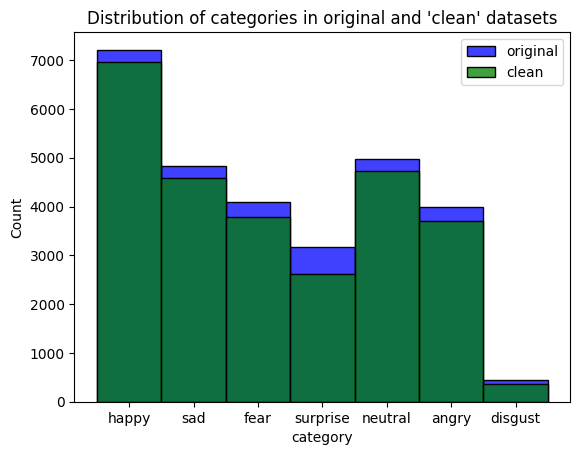

In [7]:
sns.histplot(data=df_meta_original, x="category",color="blue", label="original" )
sns.histplot(data=df_meta_train, x="category", color="green", label="clean")

plt.legend()
plt.title("Distribution of categories in original and 'clean' datasets")
plt.show()

## Modifying Images

There are several ways that we can modify existing images to augment our dataset.

`tf.keras.layers` has the most intuitive interface so we will use this going forward.

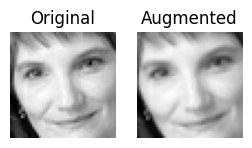

In [102]:
image_path = df_meta_train["file_path"].iloc[0]
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=1) # 1 for grayscale
img = tf.image.resize(img, [48, 48])
img = img / 255.0
img = tf.expand_dims(img, axis=0)

def augment_image(image, min_zoom=0.8, max_zoom=1.0):
    # Apply random zoom
    zoom_factor = tf.random.uniform([], min_zoom, max_zoom, dtype=tf.float32)
    image = tf.image.central_crop(image, central_fraction=zoom_factor)
    image = tf.image.resize(image, [48, 48])  # Resize back to original size

    # Random flip
    image = tf.image.random_flip_left_right(image)
    return image

augmented_image = augment_image(img)

# Plot the original and augmented image for comparison
fig, ax = plt.subplots(1, 2, figsize=(3, 2))
ax[0].imshow(img[0].numpy().squeeze(), cmap="gray")  # Display the original image (remove the batch dimension)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(augmented_image[0].numpy().squeeze(), cmap="gray")  # Display the augmented image
ax[1].set_title("Augmented")
ax[1].axis('off')

plt.show()

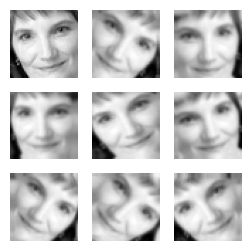

In [116]:
# Augmentation Layers
rotation_layer = tf.keras.layers.RandomRotation(0.1)  # Rotate by up to 10% of 360 degrees
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05)  # Zoom by 5%
shift_layer = tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)  # Shift by 5%
flip_layer = tf.keras.layers.RandomFlip("horizontal")

def augment_image(image):
    image = rotation_layer(image)  # Apply random rotation
    image = zoom_layer(image)  # Apply random zoom
    image = shift_layer(image)  # Apply random translation (shift)
    image = flip_layer(image)
    
    return image

image_path = df_meta_train["file_path"].iloc[0]
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=1) # 1 for grayscale
img = tf.image.resize(img, [48, 48])
img = img / 255.0
basic_img = tf.expand_dims(img, axis=0)


fig, ax = plt.subplots(3, 3, figsize=(3, 3))  # Adjust grid size
for i in range(3):
    for j in range(3):
        img = basic_img
        if ((i != 0) or (j!=0)):
            img = augment_image(img)
        ax[i, j].imshow(img[0].numpy().squeeze(), cmap="gray")
        ax[i, j].axis('off')  

plt.show()